# Feature Engineering & EDA of datasets

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import datetime
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Set the path to the dataset
datasetspath = "/Users/saransathy/WalshDBA/Capstone"

## Audi eTron Data Processing

In [3]:
# Read all the data
etron_chargedata = pd.read_pickle(f"{datasetspath}/Charge.pkl")
etron_drivedata = pd.read_pickle(f"{datasetspath}/Drive.pkl")

In [4]:
# Data Description
print("Description of eTron Charge Data")
for name, s in etron_chargedata.items():
    print(f"{name}'s Shape: {s.shape}")
    print(f"Sample Record:\n {s.sample()}\n")

Description of eTron Charge Data
Curr's Shape: (90536100, 1)
Sample Record:
                                Curr
TimeCurr                           
2020-01-03 20:28:10.239012957 -11.0

Volt's Shape: (90536100, 1)
Sample Record:
                                 Volt
TimeVolt                            
2020-07-27 15:59:48.167279959  428.5

SoC's Shape: (90537351, 1)
Sample Record:
                                 SoC
TimeSoC                            
2020-07-24 20:00:16.221862078  95.6

Temp's Shape: (1810460, 1)
Sample Record:
                                Temp
TimeTemp                           
2019-11-28 08:12:56.495434999  16.5



In [5]:
print("Description of eTron Drive Data")
for name, s in etron_drivedata.items():
    print(f"{name}'s Shape: {s.shape}")
    print(f"Sample Record:\n {s.sample()}\n")

Description of eTron Drive Data
Curr's Shape: (33690335, 1)
Sample Record:
                                Curr
TimeCurr                           
2020-06-24 18:48:16.244843960 -99.0

Volt's Shape: (33690335, 1)
Sample Record:
                                  Volt
TimeVolt                             
2019-11-27 14:53:48.631346941  391.25

SoC's Shape: (33691644, 1)
Sample Record:
                                 SoC
TimeSoC                            
2019-12-20 20:30:52.815642118  95.1

Temp's Shape: (673459, 1)
Sample Record:
                                Temp
TimeTemp                           
2020-09-17 18:11:17.279977083  20.5



In [6]:
# Merge Curr and Volt DataFrames, as they form same time series
cvdf = pd.concat([etron_chargedata['Curr'],etron_chargedata['Volt']],axis=1)
d_cvdf = pd.concat([etron_drivedata['Curr'],etron_drivedata['Volt']],axis=1)
print(f"Charge Data Merged Frame Shape: {cvdf.shape}")
print(f"Charge Data Sample Record:\n {cvdf.sample()}\n")
print(f"Drive Data Merged Frame Shape: {d_cvdf.shape}")
print(f"Drive Data Sample Record:\n {d_cvdf.sample()}\n")

Charge Data Merged Frame Shape: (90536100, 2)
Charge Data Sample Record:
                                Curr    Volt
2019-12-21 07:14:13.918210030  -1.0  420.25

Drive Data Merged Frame Shape: (33690335, 2)
Drive Data Sample Record:
                                 Curr    Volt
2020-01-23 23:01:41.430713892  140.0  408.75



In [7]:
# The multi vehicle data used 10s sampling rate for recorded features of Charge cycles, hence the same will be used.
# The Audi e-tron uses 1s sampling rate and time are stored in floating point unit sometimes less than a second as well. 
# We will round off the time to nearest 10s and take median of the values recorded in that 10s time frame.
# The Drive cycle data will be resampled to 10s as well to align with Charge cycle data.
cdf = cvdf.resample('10S').apply('median').dropna()
sdf = etron_chargedata['SoC'].resample('10S').apply('median').dropna()
tdf = etron_chargedata['Temp'].resample('10S').apply('median').dropna()
print(f"cv shape: {cdf.shape}")
print(f"SoC Shape: {sdf.shape}")
print(f"Temp Shape: {tdf.shape}")

cv shape: (90680, 2)
SoC Shape: (90680, 1)
Temp Shape: (90661, 1)


In [8]:
# Downsample the Drive data to 1s interval
d_cdf = d_cvdf.resample('1S').apply('median').dropna()
d_sdf = etron_drivedata['SoC'].resample('1S').apply('median').dropna()
d_tdf = etron_drivedata['Temp'].resample('30S').apply('median').fillna(method='ffill').fillna(method='bfill')
print(f"cv shape: {d_cdf.shape}")
print(f"SoC Shape: {d_sdf.shape}")
print(f"Temp Shape: {d_tdf.shape}")

cv shape: (337286, 2)
SoC Shape: (337303, 1)
Temp Shape: (1018712, 1)


In [9]:
# Compute Charge Impedance
# Formula: The mathematical formula to compute Charging Impedance (ZCHG) at a specific time instant (tk) is defined as follows:
# ZCHG(tk) = - (V(tk+Dt) - V(tk)) / I = - ΔV / I
# R(tk) = - (Vt2 - Vt1)/(It2 - It1)
# Get the index of the next row (shifted up)
next_index = d_cdf.index.to_series().shift(-1)

# Compute time difference to next row, in seconds
timedelta = (next_index - d_cdf.index.to_series()).dt.total_seconds()

# Compute the result for ALL rows
imp_calc = (d_cdf['Volt'].shift(-1) - d_cdf['Volt']) / d_cdf['Curr']
res_calc = -(d_cdf['Volt'].shift(-1) - d_cdf['Volt']) / (d_cdf['Curr'].shift(-1) - d_cdf['Curr'])


# Use .where() to keep results only where mask is True, rest will be 0
d_cdf['Impedance'] = imp_calc.where(timedelta == 1)
d_cdf['Resistance'] = res_calc.where(timedelta == 1)
d_cdf['Impedance'] = d_cdf['Impedance'].fillna(0).replace([np.inf, -np.inf], 0)
d_cdf['Resistance'] = d_cdf['Resistance'].fillna(0).replace([np.inf, -np.inf], 0)

# Release Memory
del next_index, timedelta, imp_calc, res_calc

### Perform Statistical to test to check the downsampled data represents the full data

In [10]:
# First lets test the statistics
print("############  Charge Data Stats  ################")
print(f"Original Current Volt Stats:\n {cvdf.describe().T}\n")
print(f"Downsampled Current Volt Stats:\n {cdf.describe().T}\n")
print(f"Original SoC Stats:\n {etron_chargedata['SoC'].describe().T}\n")
print(f"Downsampled SoC Stats:\n {sdf.describe().T}\n")
print(f"Original Temp Stats:\n {etron_chargedata['Temp'].describe().T}\n")
print(f"Downsampled SoC Stats:\n {tdf.describe().T}\n")

############  Charge Data Stats  ################
Original Current Volt Stats:
            count        mean        std    min    25%     50%    75%    max
Curr  90536100.0   -9.994837  26.813392 -351.0  -12.0   -1.00   -1.0   22.0
Volt  90536100.0  425.206877  17.122337  377.0  416.0  425.25  440.0  458.5

Downsampled Current Volt Stats:
         count        mean        std    min    25%     50%    75%    max
Curr  90680.0   -9.969398  26.781260 -348.0  -12.0   -1.00   -1.0    6.0
Volt  90680.0  425.207769  17.138374  377.5  416.0  425.25  440.0  458.5

Original SoC Stats:
           count       mean        std   min    25%    50%    75%    max
SoC  90537351.0  73.050006  16.809238  14.3  65.95  74.35  87.35  97.05

Downsampled SoC Stats:
        count       mean        std   min    25%    50%    75%    max
SoC  90680.0  73.048355  16.827736  14.3  65.95  74.35  87.35  97.05

Original Temp Stats:
           count       mean       std   min   25%   50%   75%   max
Temp  1810460.0  22.

In [11]:
# First lets test the statistics
print("############  Drive Data Stats  ################")
print(f"Original Current Volt Stats:\n {d_cvdf.describe().T}\n")
print(f"Downsampled Current Volt Stats:\n {d_cdf.describe().T}\n")
print(f"Original SoC Stats:\n {etron_drivedata['SoC'].describe().T}\n")
print(f"Downsampled SoC Stats:\n {d_sdf.describe().T}\n")
print(f"Original Temp Stats:\n {etron_drivedata['Temp'].describe().T}\n")
print(f"Downsampled SoC Stats:\n {d_tdf.describe().T}\n")

############  Drive Data Stats  ################
Original Current Volt Stats:
            count        mean        std     min     25%    50%    75%    max
Curr  33690335.0   21.983264  83.868501 -524.00   -0.00    4.0   61.0  990.0
Volt  33690335.0  419.063200  19.384901  347.75  404.25  420.5  435.0  458.5

Downsampled Current Volt Stats:
                count        mean        std     min        25%    50%  \
Curr        337286.0   22.004114  83.552335 -465.00    0.00000    4.0   
Volt        337286.0  419.065459  19.386428  348.75  404.25000  420.5   
Impedance   337286.0   -0.001879   0.288741  -24.50   -0.00125    0.0   
Resistance  337286.0    0.018138   0.046017   -1.75    0.00000    0.0   

                   75%     max  
Curr         61.000000  977.50  
Volt        435.000000  458.50  
Impedance     0.000000   20.00  
Resistance    0.029762    1.25  

Original SoC Stats:
           count      mean        std    min   25%   50%   75%    max
SoC  33691644.0  70.05366  18.6205

In [12]:
# Merging all the Charge Stats into a single dataframe
charge_df = pd.concat([cdf, sdf, tdf], axis=1).dropna()
print(f"Charge Data Frame Stats:\n {charge_df.describe().T}")
# Release temporary variables
del cdf, sdf, tdf

Charge Data Frame Stats:
         count        mean        std    min     25%     50%     75%     max
Curr  90661.0   -9.971487  26.783677 -348.0  -12.00   -1.00   -1.00    6.00
Volt  90661.0  425.205438  17.136026  377.5  416.00  425.25  440.00  458.50
SoC   90661.0   73.046546  16.825630   14.3   65.95   74.35   87.35   97.05
Temp  90661.0   22.990999   3.934783   12.0   20.50   23.50   26.00   37.00


In [13]:
# Merging all the Drive Stats into a single dataframe
drive_df = pd.concat([d_cdf, d_sdf, d_tdf], axis=1).dropna()
print(f"Drive Data Frame Stats:\n {drive_df.describe().T}")
# Release temporary variables
del d_cdf, d_sdf, d_tdf

Drive Data Frame Stats:
               count        mean        std      min         25%     50%  \
Curr        11254.0   21.928248  84.227591 -378.500    0.000000    4.00   
Volt        11254.0  419.110927  19.418686  360.875  404.500000  420.75   
Impedance   11254.0   -0.000674   0.286763   -6.000   -0.001193    0.00   
Resistance  11254.0    0.017814   0.047615   -1.000    0.000000    0.00   
SoC         11254.0   70.090879  18.627849   16.200   59.050000   73.40   
Temp        11254.0   22.971677   4.870918   11.000   20.000000   23.00   

                   75%      max  
Curr         60.000000  916.000  
Volt        435.250000  458.250  
Impedance     0.001246    9.625  
Resistance    0.030000    0.500  
SoC          85.300000   96.950  
Temp         26.000000   37.000  


In [14]:
# T-Test for Charge Data Downsampling
from scipy.stats import ttest_ind
cstat, cp = ttest_ind(cvdf, charge_df[['Curr','Volt']], equal_var=False)
print(f"Charge Data: Current & Volt T-test p-value: {cp}")
sstat, sp = ttest_ind(etron_chargedata['SoC'], charge_df[['SoC']], equal_var=False)
print(f"Charge Data: SoC T-test p-value: {sp}")
tstat, tp = ttest_ind(etron_chargedata['Temp'], charge_df[['Temp']], equal_var=False)
print(f"Charge Data: Temp T-test p-value: {tp}")

# The resulting p-value for all data is > 0.05, indicating that the downsampled data is clear representation of original data

Charge Data: Current & Volt T-test p-value: [0.79303993 0.97984493]
Charge Data: SoC T-test p-value: [0.95065938]
Charge Data: Temp T-test p-value: [0.97677989]


In [15]:
# T-Test for Drive Data Downsampling
d_cstat, d_cp = ttest_ind(d_cvdf, drive_df[['Curr','Volt']], equal_var=False)
print(f"Drive Data: Current & Volt T-test p-value: {d_cp}")
d_sstat, d_sp = ttest_ind(etron_drivedata['SoC'], drive_df[['SoC']], equal_var=False)
print(f"Drive Data: SoC T-test p-value: {d_sp}")
d_tstat, d_tp = ttest_ind(etron_drivedata['Temp'], drive_df[['Temp']], equal_var=False)
print(f"Drive Data: Temp T-test p-value: {d_tp}")

# The resulting p-value for all data is > 0.05, indicating that the downsampled data is representing the original population

Drive Data: Current & Volt T-test p-value: [0.9447664  0.79433289]
Drive Data: SoC T-test p-value: [0.83217101]
Drive Data: Temp T-test p-value: [0.14676601]


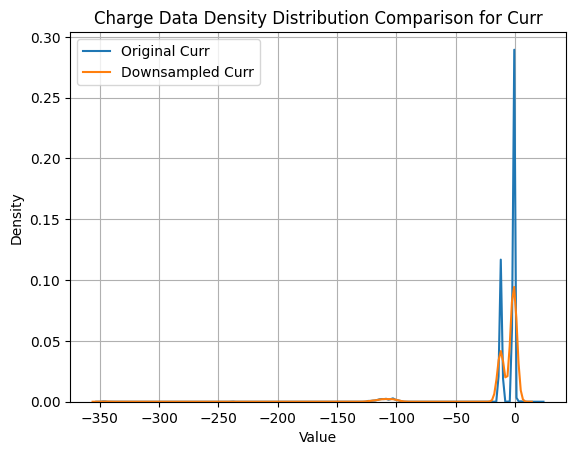

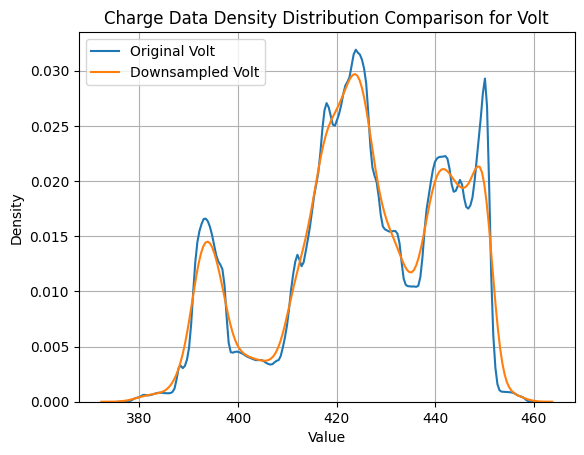

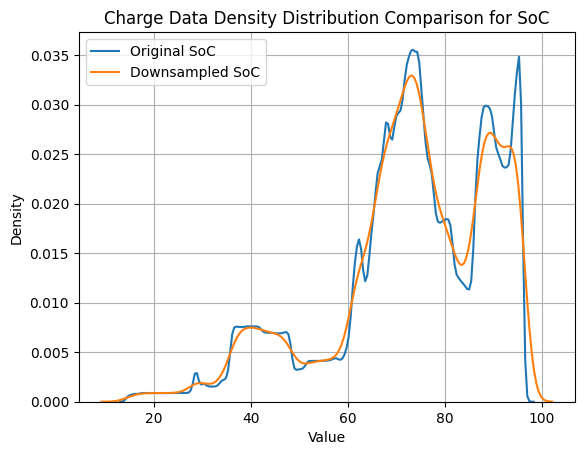

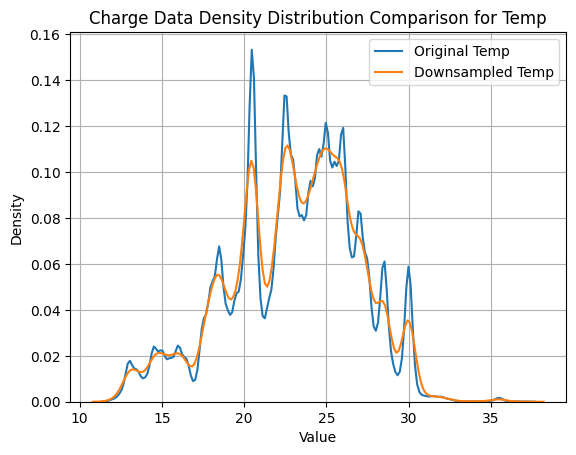

In [16]:
# Lets look at visual distribution of charge data
import matplotlib.pyplot as plt
import seaborn as sns

for key in charge_df.columns:
    sns.kdeplot(etron_chargedata[key], label=f"Original {key}", bw_adjust=1)
    sns.kdeplot(charge_df[key], label=f"Downsampled {key}", bw_adjust=1)
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.title(f"Charge Data Density Distribution Comparison for {key}")
    plt.legend()
    plt.grid(True)
    plt.show()

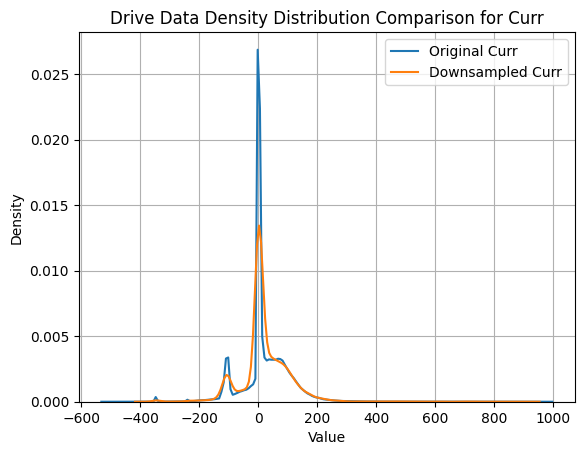

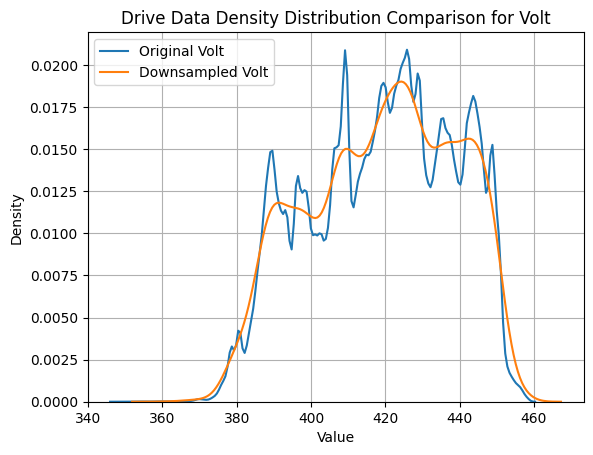

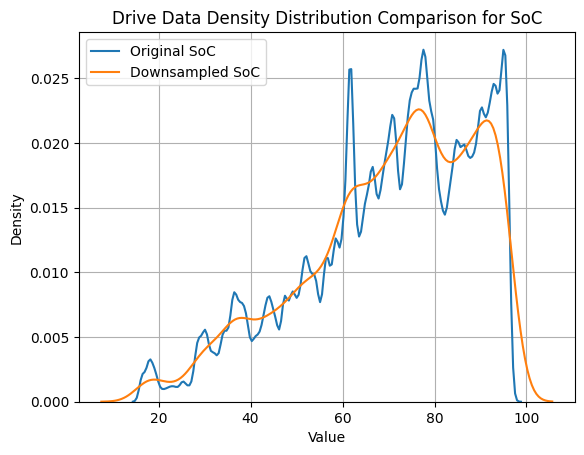

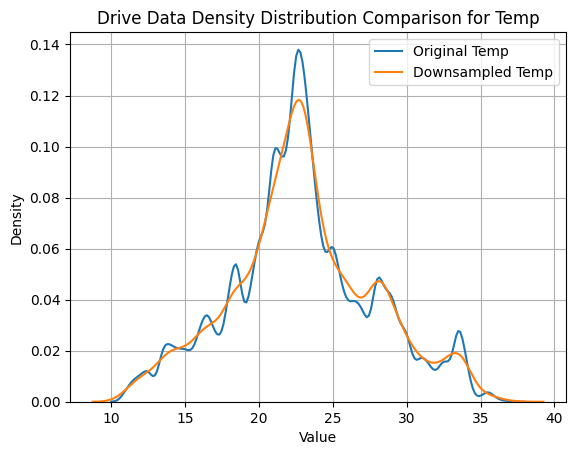

In [17]:
# Lets look at visual distribution of drive data
import matplotlib.pyplot as plt
import seaborn as sns

for key in charge_df.columns:
    sns.kdeplot(etron_drivedata[key], label=f"Original {key}", bw_adjust=1)
    sns.kdeplot(drive_df[key], label=f"Downsampled {key}", bw_adjust=1)
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.title(f"Drive Data Density Distribution Comparison for {key}")
    plt.legend()
    plt.grid(True)
    plt.show()

In [18]:
charge_df.head(10)

,Curr,Volt,SoC,Temp
2019-11-02 03:58:10,-0.0,437.0,86.0,26.5
2019-11-02 03:58:20,-0.0,437.0,86.0,26.5
2019-11-02 03:58:30,-0.0,437.0,86.0,26.5
2019-11-02 03:58:40,-0.0,437.0,86.0,26.5
2019-11-02 03:58:50,-0.0,437.0,86.0,26.5
2019-11-02 03:59:00,-0.0,437.0,86.0,26.5
2019-11-02 03:59:10,-1.0,437.0,86.0,26.5
2019-11-02 03:59:20,-1.0,437.0,86.0,26.5
2019-11-02 03:59:30,-1.0,437.0,86.0,26.5
2019-11-02 03:59:40,-1.0,437.0,86.0,26.5


In [19]:
drive_df.head(10)

,Curr,Volt,Impedance,Resistance,SoC,Temp
2019-11-01 21:05:00,5.0,448.500,0.000000,0.000000,94.90,23.0
2019-11-01 21:05:30,7.0,448.250,-0.071429,0.029412,94.90,23.0
2019-11-01 21:06:00,1.0,447.000,0.000000,-0.000000,94.65,23.0
2019-11-01 21:06:30,53.5,446.250,-0.004673,0.016129,94.65,23.0
2019-11-01 21:07:00,97.0,443.750,-0.002577,0.041667,94.35,23.0
2019-11-01 21:07:30,42.0,445.000,0.000000,0.000000,94.10,23.0
2019-11-01 21:08:00,328.0,436.875,0.006479,0.026899,94.05,23.0
2019-11-01 21:08:30,38.0,445.500,0.006579,0.062500,94.00,23.0
2019-11-01 21:09:00,38.0,445.000,0.013158,0.026316,93.85,23.0
2019-11-01 21:09:30,84.0,443.000,0.023810,0.026846,93.60,23.0


In [20]:
# Write the feature engineered charge & drive data into pkl file
charge_df.to_pickle(f"{datasetspath}/charge_downsampled.pkl")
drive_df.to_pickle(f"{datasetspath}/drive_downsampled.pkl")

In [21]:
# Perform Z-Scalar Transformation
charge_df[charge_df.columns] = (charge_df - charge_df.mean()) / charge_df.std(ddof=0)
drive_df[drive_df.columns] = (drive_df - drive_df.mean()) / drive_df.std(ddof=0)

In [22]:
# Write the Normalized charge & drive data into pkl file
charge_df.to_pickle(f"{datasetspath}/charge_normalised.pkl")
drive_df.to_pickle(f"{datasetspath}/drive_normalised.pkl")

In [23]:
# Release Memory
del etron_chargedata, etron_drivedata, charge_df, drive_df

## Read & Perform ZScalar Transformation on the Multivehicle Dataset

In [24]:
mv_dataset1 = pd.read_pickle(f"{datasetspath}/battery_dataset1.pkl")
mv_dataset2 = pd.read_pickle(f"{datasetspath}/battery_dataset2.pkl")
mv_dataset3 = pd.read_pickle(f"{datasetspath}/battery_dataset3.pkl")

In [27]:
# Perform Z-Scalar Transformation on the data
cols = ["Curr","Volt","SoC","Temp","MaxVolt","MinVolt","MinTemp"]
for i,df in enumerate([mv_dataset1,mv_dataset2,mv_dataset3]):
    df[cols] = (df[cols] - df[cols].mean()) / df[cols].std(ddof=0)
    df.to_pickle(f"{datasetspath}/battery_dataset{i+1}_normalised.pkl")

In [55]:
# Check whether the patterns looks similar for different cars
mv_group1 = mv_dataset1.groupby(['car'])
mv_group2 = mv_dataset2.groupby(['car'])
mv_group3 = mv_dataset3.groupby(['car'])

In [42]:
mv_dataset1.head()

,label,mileage,capacity,car,charge_segment,Curr,SoC,Temp,Volt
0,00,87968.496,0.0,0,1,-42.700000,4.000000,11.0,3.761364
1,00,87968.496,0.0,0,1,-42.766667,4.333333,11.0,3.768182
2,00,87968.496,0.0,0,1,-42.833333,4.666667,11.0,3.775000
3,00,87968.496,0.0,0,1,-42.900000,5.000000,11.0,3.781818
4,00,87968.496,0.0,0,1,-42.933333,5.000000,11.0,3.784470


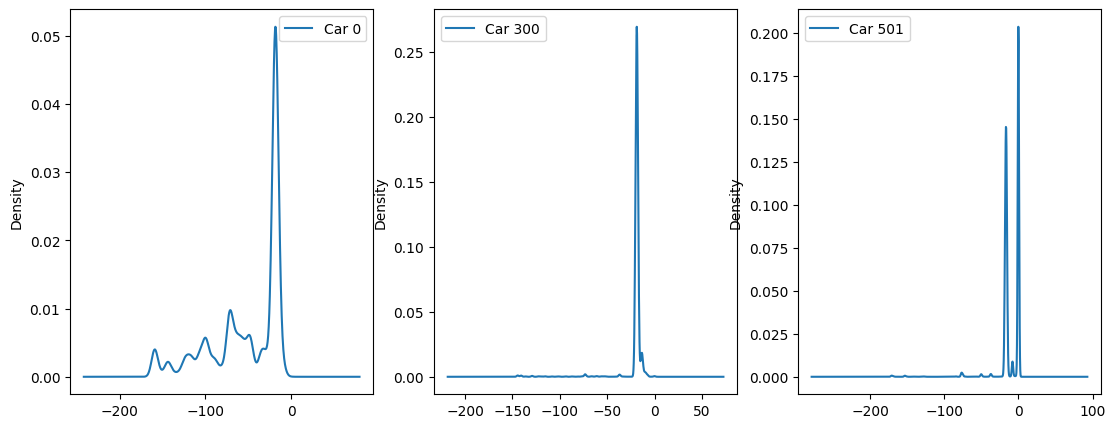

In [68]:
plt.figure(figsize=(18, 5))
plt.subplot(1, 4, 1)
mv_group1.get_group((0))['Curr'].plot(kind='kde', label='Car 0')
plt.legend()
plt.subplot(1, 4, 2)
mv_group2.get_group((300))['Curr'].plot(kind='kde', label='Car 300')
plt.legend()
plt.subplot(1, 4, 3)
mv_group3.get_group((501))['Curr'].plot(kind='kde', label='Car 501')
plt.legend()

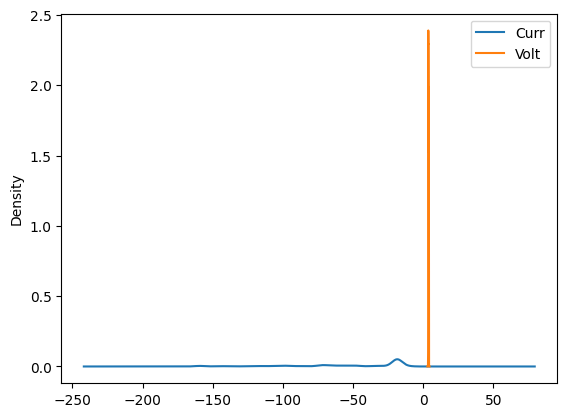

In [ ]:
plt.figure()
mv_group1.get_group((0))['Curr'].plot(kind='kde', label='Curr')
mv_group1.get_group((0))['Volt'].plot(kind='kde', label='Volt')
plt.legend()